# Используемые библиотеки

In [284]:
import gc # сборщик мусора

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor

#https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization

1) Выгрузка данных
2) Работа с данными
3) Обучение и тренировка
4) Обучение финальной модели

# Функции, используемые в коде

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [6]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [7]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

# Загрузка данных

In [1521]:
df = pd.read_csv('Data set to train.csv')

In [1522]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [1523]:
X_final = pd.read_csv('Data set to test X.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

In [1524]:
df.describe()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,13828.000000,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000,13828.000000
mean,10321.331284,-119.489883,34.763235,28.569706,2647.567255,540.267139,1430.854271,501.675441,3.876745,206663.620480
std,5978.680134,4.857729,115.937671,12.582947,2171.663363,421.248573,1148.827206,383.639299,1.903102,115374.273364
min,1.000000,-124.350000,-13534.030000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,5132.750000,-121.810000,33.940000,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575,119400.000000
50%,10373.500000,-118.510000,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750,179200.000000
75%,15524.250000,-118.010000,37.720000,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600,264025.000000
max,20639.000000,121.290000,1327.130000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [1525]:
m = df['median_house_value'].max()

In [1526]:
df[df['median_house_value'] == m].describe()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,647.000000,647.000000,647.000000,615.000000,647.000000,647.000000,631.000000,647.000000,647.000000,647.0
mean,11052.211747,-119.408655,35.294869,34.144715,3023.115920,512.333849,1130.851030,474.197836,7.862960,500001.0
std,5346.774154,9.563731,1.793080,13.338253,2265.761497,384.960980,839.560391,348.298928,3.260615,0.0
min,89.000000,-122.640000,32.680000,2.000000,8.000000,1.000000,13.000000,1.000000,0.499900,500001.0
25%,5726.000000,-122.140000,34.015000,24.000000,1662.000000,268.000000,650.500000,257.000000,5.295450,500001.0
50%,9414.000000,-118.490000,34.130000,34.000000,2533.000000,411.000000,935.000000,378.000000,7.784800,500001.0
75%,16897.500000,-118.345000,37.430000,45.000000,3593.500000,626.500000,1365.000000,592.000000,10.077550,500001.0
max,20443.000000,118.410000,38.910000,52.000000,17591.000000,2611.000000,6897.000000,2492.000000,15.000100,500001.0


In [1527]:
df[df['median_house_value'] != m].describe()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,13181.000000,13181.000000,13181.000000,12734.000000,13181.000000,13181.000000,12798.000000,13181.000000,13181.000000,13181.000000
mean,10285.455428,-119.493870,34.737139,28.300455,2629.133146,541.638267,1445.645804,503.024202,3.681079,192264.918974
std,6005.879642,4.502505,118.748517,12.482997,2165.352279,422.915542,1159.967331,385.252165,1.568496,97638.765165
min,1.000000,-124.350000,-13534.030000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,5003.000000,-121.770000,33.940000,18.000000,1445.000000,298.000000,799.000000,282.000000,2.534300,116400.000000
50%,10380.000000,-118.520000,34.280000,28.000000,2122.000000,438.000000,1181.000000,414.000000,3.454500,173500.000000
75%,15425.000000,-118.000000,37.730000,37.000000,3141.000000,649.000000,1751.000000,608.000000,4.596200,247900.000000
max,20639.000000,121.290000,1327.130000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,500000.000000


In [1528]:
X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
#del df
#gc.collect()  

Строк в трейне: 13828
Строк в тесте 6812


In [1529]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [1530]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [1531]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [1532]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           13828 non-null  float32 
 1   latitude            13828 non-null  float32 
 2   housing_median_age  13349 non-null  float32 
 3   total_rooms         13828 non-null  float32 
 4   total_bedrooms      13828 non-null  float32 
 5   population          13429 non-null  float32 
 6   households          13828 non-null  float32 
 7   median_income       13828 non-null  float32 
 8   ocean_proximity     13828 non-null  category
dtypes: category(1), float32(8)
memory usage: 553.9 KB


In [1533]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [1534]:
X.shape

(13828, 9)

In [1535]:
X[['longitude', 'latitude']].head(5)

,longitude,latitude
Id,,
5088,-118.279999,33.980000
17096,-122.230003,37.459999
5617,-118.260002,33.790001
20060,-119.260002,35.869999
895,-121.959999,37.540001


In [1536]:
X[(X['longitude'] < 120) & (X['latitude'] < 34)].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
11307,-117.940002,33.779999,40.0,299.0,68.0,163.0,70.0,3.0125,<1H OCEAN
7341,-118.139999,33.970001,29.0,1846.0,530.0,2576.0,528.0,2.6300,<1H OCEAN
15142,-116.889999,32.820000,18.0,2515.0,443.0,1442.0,449.0,5.0201,<1H OCEAN
7731,-118.139999,33.919998,31.0,3731.0,853.0,2313.0,801.0,3.2237,<1H OCEAN
12386,-116.389999,33.689999,10.0,11659.0,2007.0,2186.0,1083.0,6.9833,INLAND
8366,-118.349998,33.970001,26.0,3832.0,1074.0,2340.0,904.0,2.6734,<1H OCEAN
8238,-118.180000,33.770000,39.0,1645.0,547.0,1339.0,499.0,1.5536,NEAR OCEAN


## Количественные переменные

In [1537]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.569706,2647.572998,540.267151,1430.852661,501.675446,3.876735
std,4.857742,115.936920,12.583060,2171.663818,421.248840,1148.826538,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


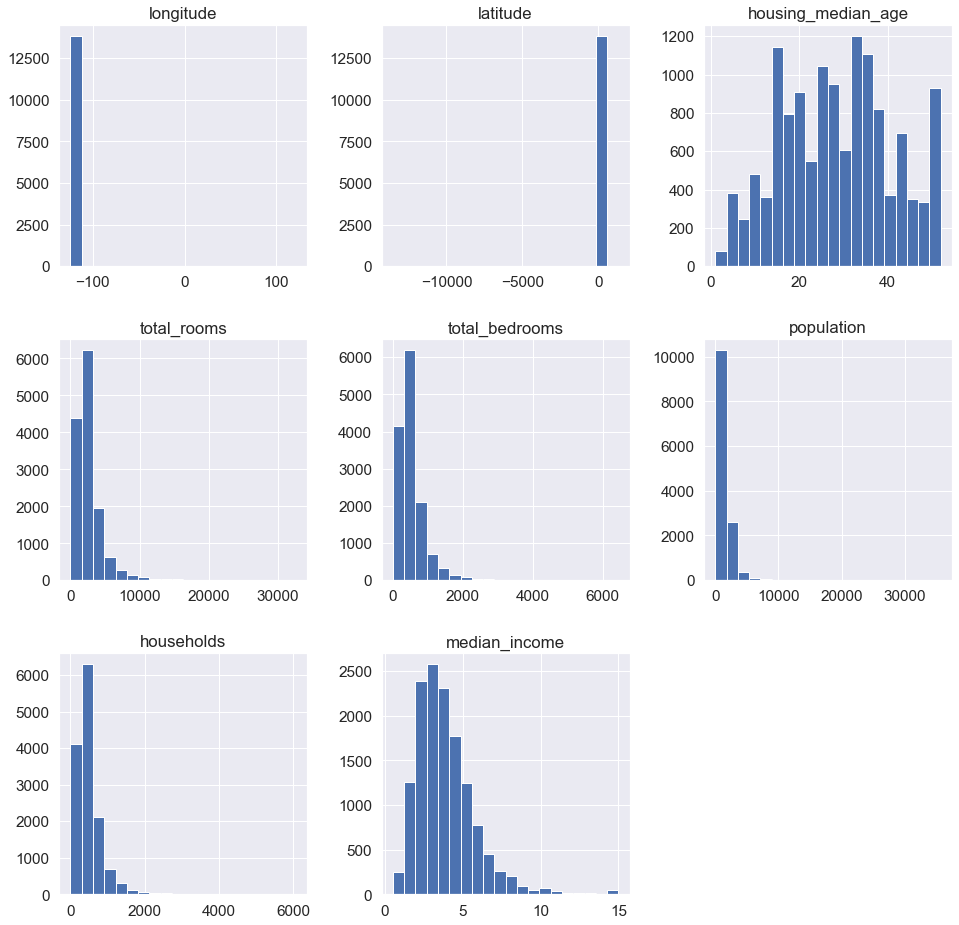

In [1538]:
X.hist(figsize=(16,16), bins=20);

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.009715           -0.039775     0.035243   
latitude            -0.009715  1.000000           -0.011278     0.005695   
housing_median_age  -0.039775 -0.011278            1.000000    -0.361614   
total_rooms          0.035243  0.005695           -0.361614     1.000000   
total_bedrooms       0.043869  0.006314           -0.321267     0.929825   
population           0.060158  0.006036           -0.290628     0.855977   
households           0.039350  0.006354           -0.302934     0.920828   
median_income       -0.003205 -0.018312           -0.115285     0.197146   

                    total_bedrooms  population  households  median_income  
longitude                 0.043869    0.060158    0.039350      -0.003205  
latitude                  0.006314    0.006036    0.006354      -0.018312  
housing_median_age       -0.321267   -0.290628   -0.302934      -0.115285  
total_rooms

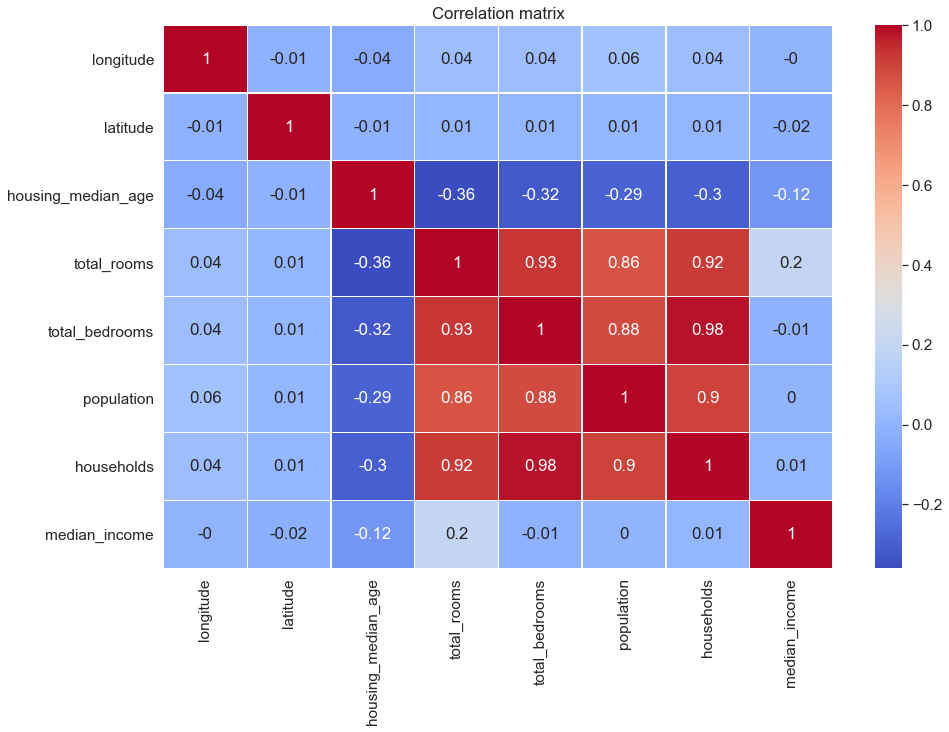

In [1539]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
#corr_matrix[np.abs(corr_matrix) < 0.2] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [1219]:
sns.set()
sns.pairplot(X, height = 4.5)
plt.show()

KeyboardInterrupt: 

In [ ]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Качественные переменные

In [1540]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

In [1541]:
base_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

KeyboardInterrupt: 

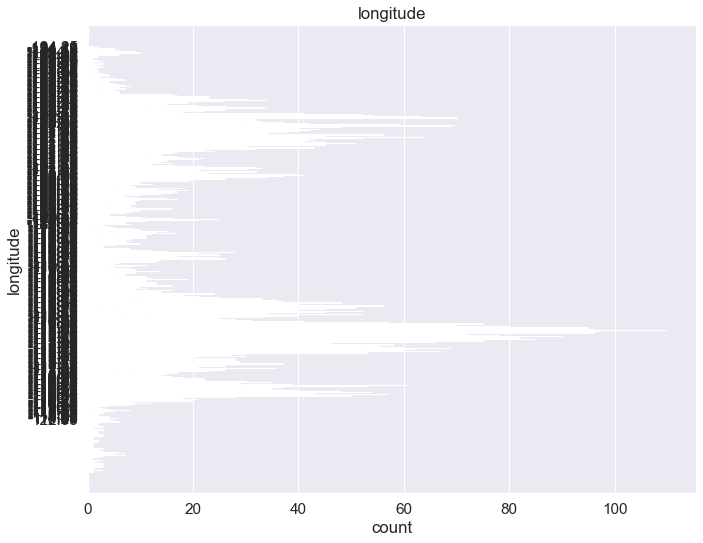

In [1503]:
plt.figure(figsize = (24, 50))

l = len(base_features)

for i in range(l):
    plt.subplot((l+1)//2,2,i+1)
    plt.title(base_features[i])
    if X[base_features[i]].dtype == 'float64':
        sns.kdeplot(X[base_features[i]], shade=True, label='train', color='r')
        sns.kdeplot(X_final[base_features[i]], shade=True, label='test', color='b')
    else:
        sns.countplot(y=base_features[i], data=X_final, color = 'b')
        sns.countplot(y=base_features[i], data=X, color = 'r')


plt.show()
#for i in range(0, 5):
#  plt.subplot(5,2,i+1)

# Анализируем и исправляем

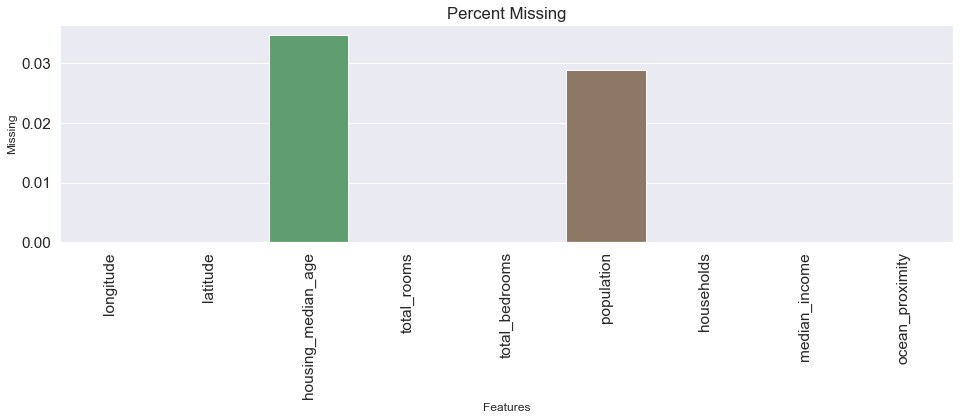

In [1542]:
nan_analize(X)

In [1543]:
def mode(str):
    X[str] = X[str].fillna(0)
    h = np.histogram(np.array(X[str]))
    mod = h[0].max()
    ind = list(h[0]).index(mod)
    mod = h[1][ind]
    return mod
        

In [1544]:

median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [1545]:
mode('housing_median_age')

31.6

In [1546]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

In [1547]:
X.loc[X['longitude'] == 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
17085,0.0,37.470001,33.0,1266.0,415.0,1991.0,334.0,2.9200,NEAR OCEAN
17359,0.0,34.880001,4.0,3680.0,559.0,1678.0,569.0,5.0639,<1H OCEAN
19423,0.0,37.689999,5.0,9601.0,1639.0,4449.0,1575.0,4.5332,INLAND


In [1548]:
# третье
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [1549]:
# четвёртое
X.loc[X['longitude'] == 0, 'longitude'] = X['longitude'].median()
X_final.loc[X_final['longitude'] == 0, 'longitude'] = X_final['longitude'].median()

In [1550]:
# пятое
median = X['latitude'].median()
X.loc[X['latitude'] < 0, 'latitude'] = median
X_final.loc[X_final['latitude'] < 0, 'latitude'] = median

In [ ]:
spisok = X['ocean_proximity'].unique()
d = {spisok[i]: (i + 1)*10 for i in range(len(spisok))}
d

In [1301]:
X['ocean_proximity_level'] = X['ocean_proximity'].map(d)
X_final['ocean_proximity_level'] = X_final['ocean_proximity'].map(d)

In [1302]:
X.drop('ocean_proximity', axis =1, inplace =True)
X_final.drop('ocean_proximity', axis =1, inplace =True)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_level
Id,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,10
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,20
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,10
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,30
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,10


In [1551]:
# седьмое
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [1552]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
Id,,,,,,,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,0,1,0,0,0,0
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,0,0,0,0,0,1
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,0,1,0,0,0,0
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,0,0,1,0,0,0
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,0,1,0,0,0,0


In [1553]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000
mean,-119.584473,35.744511,28.584610,2647.572998,540.267151,1423.267578,501.675446,3.876735,0.000940,0.444316,0.319207,0.000217,0.112236,0.123084
std,2.005016,11.188048,12.363278,2171.663818,421.248840,1132.986938,383.638641,1.903102,0.030648,0.496908,0.466186,0.014728,0.315668,0.328545
min,-124.349998,32.549999,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,801.000000,280.000000,2.568575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1710.000000,607.000000,4.756600,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.309998,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1554]:
# шестое
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [1555]:
X[X['population_per_room']>5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room
Id,,,,,,,,,,,,,,,,
13034,-121.150002,38.689999,52.0,240.0,44.0,6675.0,29.0,6.1359,INLAND,0,0,1,0,0,0,27.812500
4861,-118.279999,34.020000,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN,0,1,0,0,0,0,5.223301
13366,-117.629997,33.939999,36.0,447.0,95.0,2886.0,85.0,4.2578,INLAND,0,0,1,0,0,0,6.456376
20352,-119.089996,34.220001,8.0,40.0,10.0,309.0,16.0,4.0208,NEAR OCEAN,0,0,0,0,0,1,7.725000
16420,-121.290001,37.889999,26.0,161.0,27.0,1542.0,30.0,5.7485,INLAND,0,0,1,0,0,0,9.577640
19435,-121.040001,37.669998,16.0,19.0,19.0,166.0,9.0,0.5360,INLAND,0,0,1,0,0,0,8.736842
8874,-118.449997,34.060001,52.0,204.0,34.0,1154.0,28.0,9.3370,<1H OCEAN,0,1,0,0,0,0,5.656863
19006,-121.980003,38.320000,45.0,19.0,5.0,7460.0,6.0,10.2264,INLAND,0,0,1,0,0,0,392.631592
16643,-120.650002,35.320000,20.0,626.0,212.0,3574.0,261.0,1.0298,NEAR OCEAN,0,0,0,0,0,1,5.709265


In [1509]:
# шестое
X['population_per_bedroom'] = X['population'] / X['total_bedrooms']
X_final['population_per_bedroom'] = X_final['population'] / X_final['total_bedrooms']

In [1510]:
X.replace(X[X['population_per_bedroom']> 5]['population_per_bedroom'] , mode('population_per_room'))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,population_per_bedroom
Id,,,,,,,,,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,0,1,0,0,0,0,0.822197,2.319489
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,0,0,0,0,0,1,0.384033,2.187500
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,0,1,0,0,0,0,0.898451,3.954545
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,0,0,1,0,0,0,1.060377,4.323077
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,0,1,0,0,0,0,0.536232,2.268434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.959999,33.779999,35.0,1330.0,201.0,658.0,217.0,6.3700,<1H OCEAN,0,1,0,0,0,0,0.494737,3.273632
11964,-117.430000,34.020000,33.0,3084.0,570.0,1753.0,449.0,3.0500,INLAND,0,0,1,0,0,0,0.568418,3.075438
5390,-118.379997,34.029999,36.0,2101.0,569.0,1756.0,527.0,2.9344,<1H OCEAN,0,1,0,0,0,0,0.835792,3.086116


In [1556]:
X['population_per_room'].head()

Id 
5088     0.822197
17096    0.384033
5617     0.898451
20060    1.060377
895      0.536232
Name: population_per_room, dtype: float32

In [1557]:
X.loc[X['total_bedrooms'] + 1 > X['total_rooms'] ].head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room
Id,,,,,,,,,,,,,,,,
3126,-117.790001,35.209999,4.0,2.0,2.0,6.0,2.0,2.375,INLAND,0,0,1,0,0,0,3.000000
19435,-121.040001,37.669998,16.0,19.0,19.0,166.0,9.0,0.536,INLAND,0,0,1,0,0,0,8.736842


In [1558]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'population_per_room'],
      dtype='object')

# Проверяем модель

In [1559]:
remain_features = ['longitude', 'latitude', 'housing_median_age',
 'total_rooms','median_income', 'population_per_room', '-', '<1H OCEAN', 'INLAND',
  'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
#remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms','median_income', 'population_per_room', 'ocean_proximity_level']
X = X[remain_features]
X_final = X_final[remain_features]

                     longitude  latitude  housing_median_age  total_rooms  \
longitude             1.000000 -0.183819           -0.097868     0.036534   
latitude             -0.183819  1.000000            0.000507    -0.006884   
housing_median_age   -0.097868  0.000507            1.000000    -0.353582   
total_rooms           0.036534 -0.006884           -0.353582     1.000000   
median_income        -0.019546 -0.022771           -0.112840     0.197146   
population_per_room  -0.000687  0.000245            0.025441    -0.034326   
-                    -0.002473 -0.000082           -0.007558    -0.006780   
<1H OCEAN             0.319390 -0.093150            0.044348    -0.004016   
INLAND               -0.048538  0.078180           -0.237842     0.033447   
ISLAND                0.009266 -0.003166            0.017971    -0.004029   
NEAR BAY             -0.474220  0.065347            0.253187    -0.022610   
NEAR OCEAN            0.041261 -0.032684            0.027046    -0.018849   

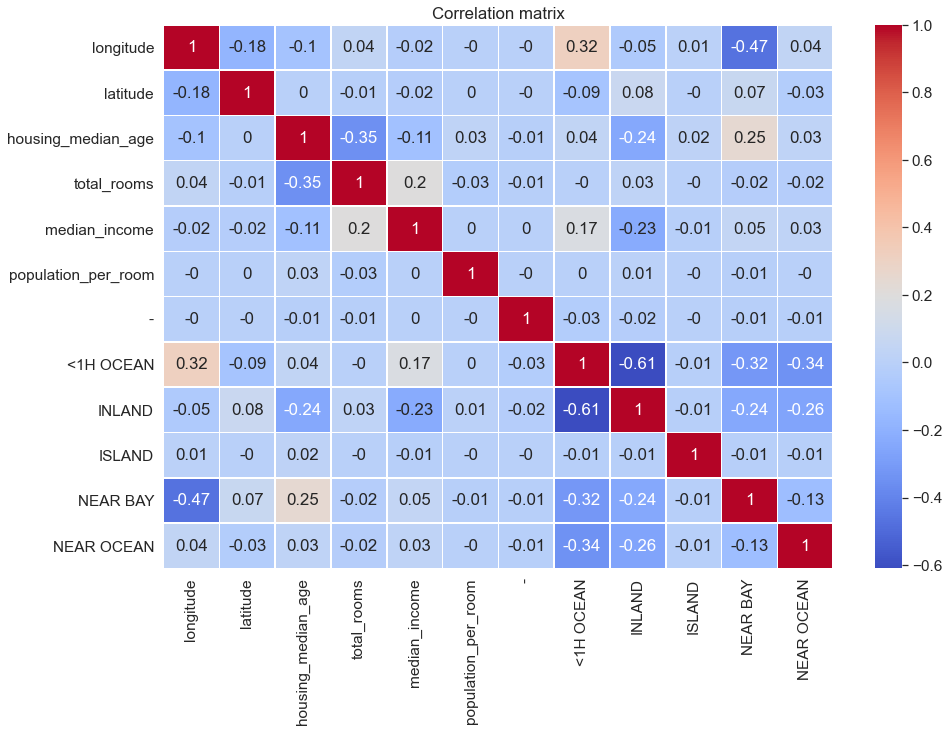

In [1560]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
#corr_matrix[np.abs(corr_matrix) < 0.2] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [1561]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1562]:
model = LGBMRegressor(max_depth=26,
                             min_samples_leaf=5,
                             n_estimators=299,
                             random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(max_depth=26, min_samples_leaf=5, n_estimators=299,
              random_state=42)

R2:	0.83561
RMSE:	46603.685
MSE:	2171903479.647


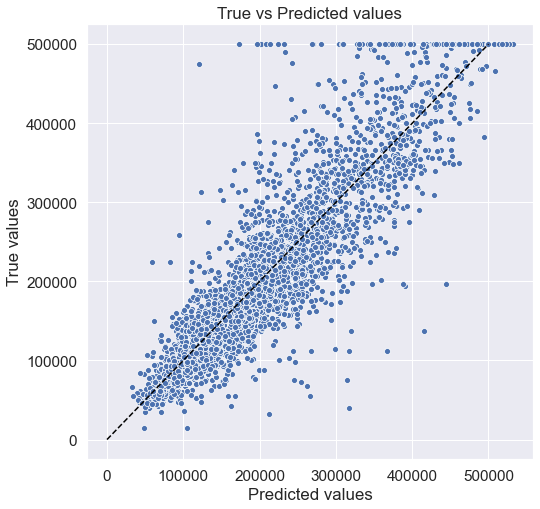

In [1563]:
y_pred_test = model.predict(X_test)
evaluate_preds(y_test['median_house_value'], y_pred_test)

In [1205]:
#0.82006
#0.81915
#0.81979
#0.82164
#0.82137
#0.82077
#0.82667
#0.82865
#0.83112

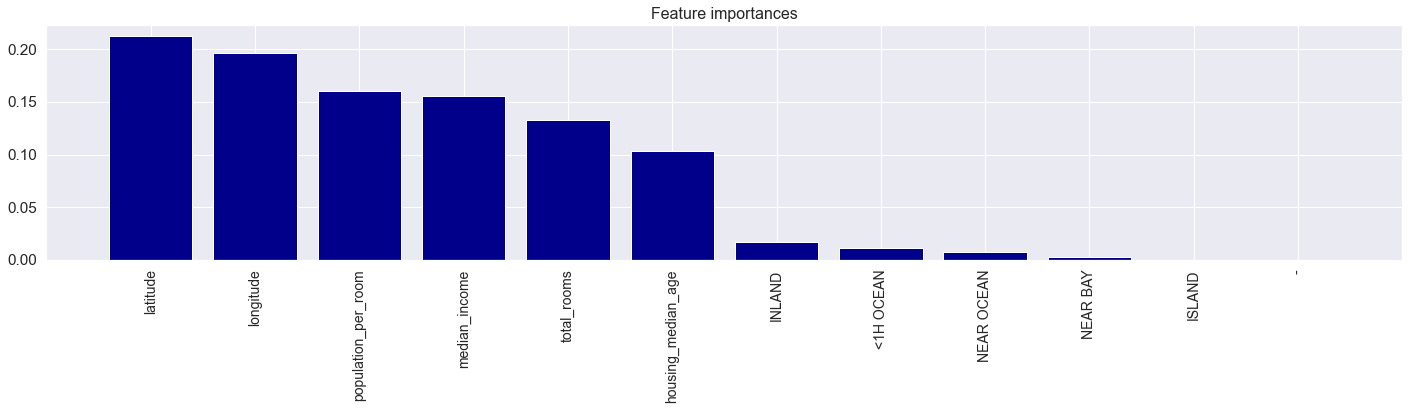

In [1444]:
plot_feature_importances(importances = model.feature_importances_, X=X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A94040E1F0>]],
      dtype=object)

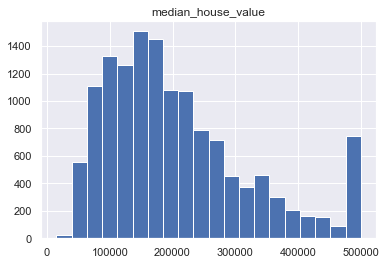

In [399]:
y.hist(bins =20)

## Учим финальную модель

In [1564]:
model_lgbm_f = LGBMRegressor(max_depth=26,
                             min_samples_leaf=5,
                             n_estimators=299,
                             random_state=42)
model_lgbm_f.fit(X, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(max_depth=26, min_samples_leaf=5, n_estimators=299,
              random_state=42)

In [1565]:
y_pred_test = model_lgbm_f.predict(X_final)
y_pred_test

array([ 47027.12801424,  75285.70674529, 509768.00530522, ...,
       122612.51987934, 136156.16351152, 305706.53940591])

In [1566]:
y_pred_df = pd.DataFrame(y_pred_test, columns=['median_house_value'])

In [1567]:
y_pred_df

,median_house_value
0,47027.128014
1,75285.706745
2,509768.005305
3,344273.215241
4,283304.337139
...,...
6807,178229.414434
6808,117356.786524
6809,122612.519879
6810,136156.163512


In [1568]:
X_final.index

Int64Index([20046,  3024, 15663, 20484,  9814, 13311,  7113,  7668, 18246,
             5723,
            ...
             6557,  3383, 16201, 18186,  3592, 15316, 14772, 12870, 13476,
            16123],
           dtype='int64', name='Id ', length=6812)

In [1569]:
filename = '201118_Kugushev_1.csv'
y_pred_df.to_csv(filename, index=None)

## Домашнее задание
Получить большую точность на тестовых данных.
yymmdd_Surn_#.csv
+ноутбук